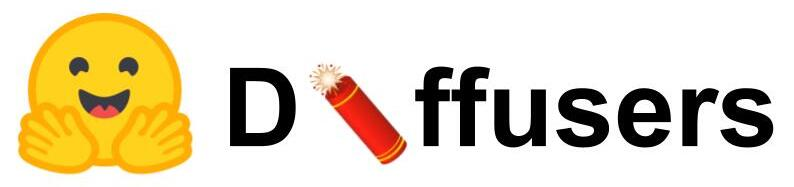

https://huggingface.co/docs/diffusers/en/index

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=transform)

Input shape: torch.Size([64, 1, 28, 28])
Labels: tensor([8, 3, 6, 8, 3, 1, 9, 1, 5, 5, 1, 7, 1, 3, 4, 5, 3, 0, 1, 3, 3, 9, 9, 3,
        3, 0, 2, 0, 0, 3, 4, 0, 9, 7, 1, 5, 7, 6, 6, 1, 4, 8, 7, 7, 0, 5, 7, 1,
        5, 1, 4, 2, 0, 6, 4, 7, 6, 7, 7, 8, 3, 9, 3, 8])


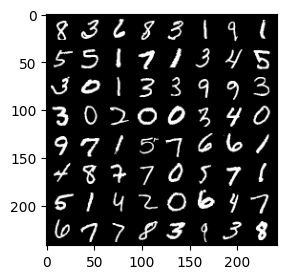

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)

plt.figure(figsize=(10,3))
plt.imshow(torchvision.utils.make_grid(x*0.5 + 0.5).permute(1,2,0).numpy())
plt.show()

# Use the Diffuser Library

In [4]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
print(scheduler)

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.35.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}



In [5]:
scheduler.alphas

tensor([0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9989, 0.9989, 0.9989, 0.9989,
        0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989,
        0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9988, 0.9988, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987, 0.9987,
        0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987,
        0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9986, 0.9986, 0.9986, 0.9986,
        0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986,
        0.9986, 0.9986, 0.9986, 0.9985, 

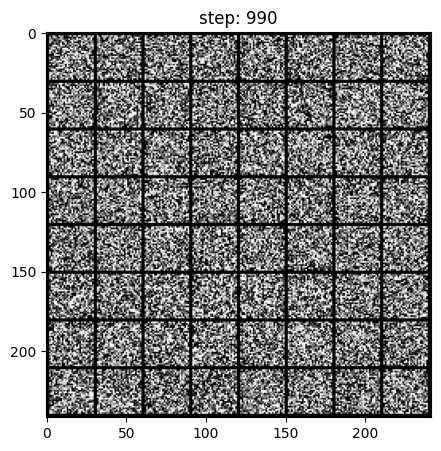

In [6]:
for t in range(scheduler.num_train_timesteps):
    noise = torch.randn_like(x)
    
    x_noised = scheduler.add_noise(x, noise, torch.tensor(t).long())
    
    if t%10==0:
        plt.figure(figsize=(5,5))
        plt.title(f'step: {t}')
        plt.imshow(torchvision.utils.make_grid(x_noised*0.5 + 0.5).permute(1,2,0).cpu().numpy())
        clear_output(wait=True)
        plt.show()

# The Unet from the Diffusers Library

In [7]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=28,
    in_channels = 1,
    out_channels = 1,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    time_embedding_dim = 128,
    down_block_types = ('DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D'),
    mid_block_type = 'UNetMidBlock2D',
    up_block_types = ( 'AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D'),
    block_out_channels= (32, 32, 64),
    class_embed_type='timestep',
    num_class_embeds=10
)

In [8]:
# count num of parameters in the model
print(f'Number of parameters in the model: {sum(p.numel() for p in unet.parameters())}')

Number of parameters in the model: 1188801


In [11]:
unet.to(device)
x=torch.randn(5,1,28,28).to(device)
t = torch.linspace(0,999,5).long().to(device)
cls = torch.randperm(5).long().to(device)

with torch.no_grad():
    output = unet(x,t,cls)

output.sample.shape

torch.Size([5, 1, 28, 28])

In [14]:
from torchinfo import summary
# Torchinfo cannot directly parse multiple inputs unless wrapped in a tuple
summary(
    unet,
    input_data=(x, t, cls),
    depth=4,          # controls nesting depth in the summary
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    verbose=0
)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
UNet2DModel                                   [5, 1, 28, 28]            [5, 1, 28, 28]            --                        --                        --
├─Timesteps: 1-1                              [5]                       [5, 32]                   --                        --                        --
├─TimestepEmbedding: 1-2                      [5, 32]                   [5, 128]                  --                        --                        --
│    └─Linear: 2-1                            [5, 32]                   [5, 128]                  4,224                     --                        21,120
│    └─SiLU: 2-2                              [5, 128]                  [5, 128]                  --                        --                        --
│    └─Linear: 2-3                            [5, 128]                 

In [12]:
def generate_image():
    xt = torch.randn(10,1,28,28).to(device)
    y = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)

    unet.eval()

    for t in tqdm(scheduler.timesteps,total=scheduler.num_train_timesteps,leave=False):
        with torch.no_grad():
            noise_pred = unet(xt,t,y).sample
            
        
        xt = scheduler.step(noise_pred, t, xt).prev_sample
        
    plt.figure(figsize=(10,3))
    plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1,2,0).cpu().numpy())
    plt.show()

c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

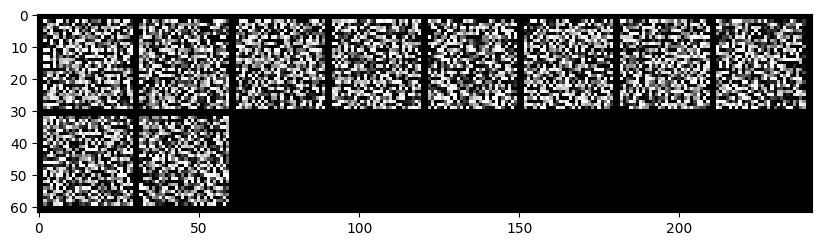

In [13]:
generate_image()

# Train the diffusion Model

  0%|          | 0/938 [00:00<?, ?it/s]

/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

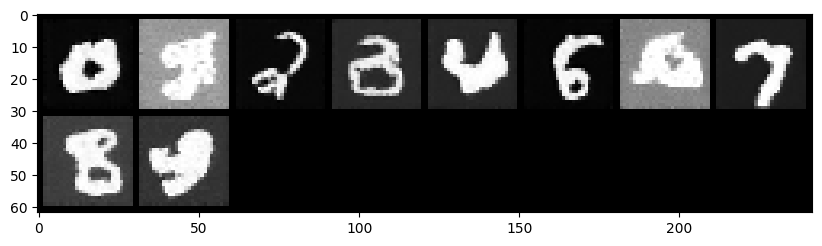

Finished epoch 0. Average of the last 100 loss values: 0.034718


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

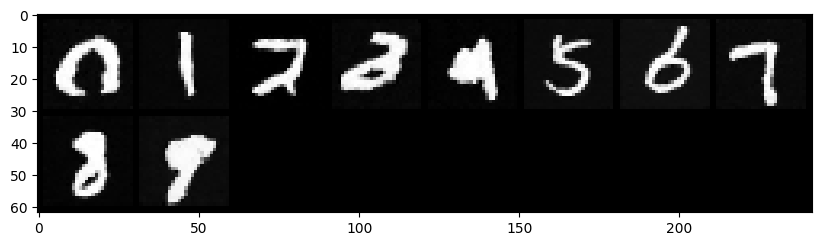

Finished epoch 1. Average of the last 100 loss values: 0.031549


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

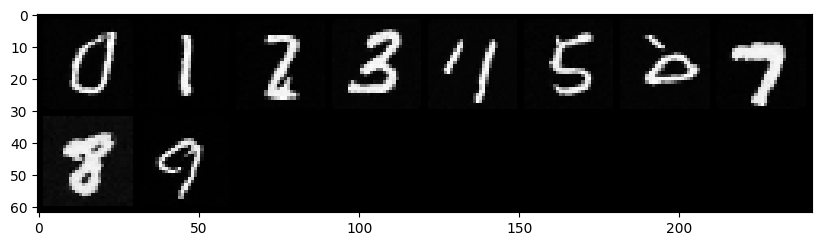

Finished epoch 2. Average of the last 100 loss values: 0.030151


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

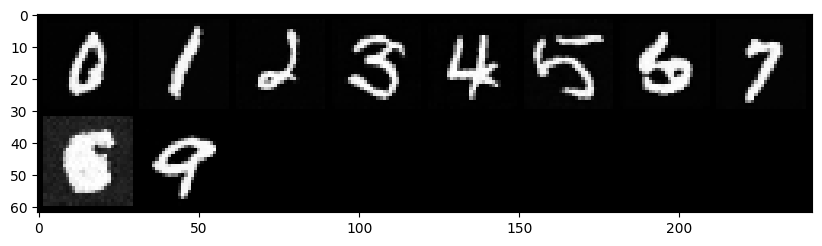

Finished epoch 3. Average of the last 100 loss values: 0.029003


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

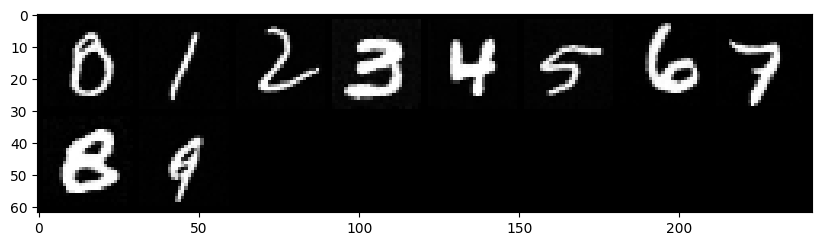

Finished epoch 4. Average of the last 100 loss values: 0.028404


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

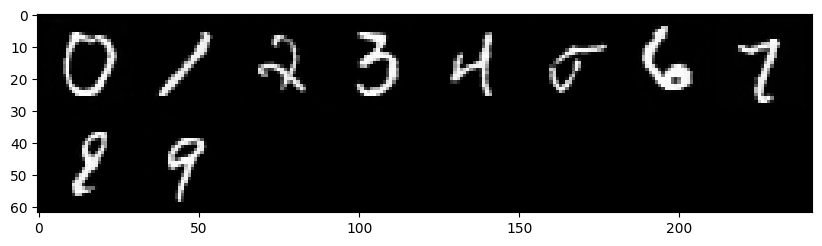

Finished epoch 5. Average of the last 100 loss values: 0.028259


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

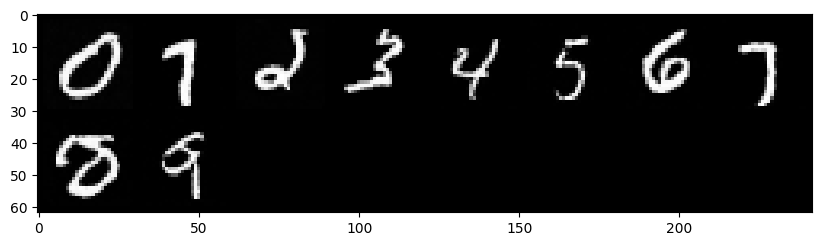

Finished epoch 6. Average of the last 100 loss values: 0.028041


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

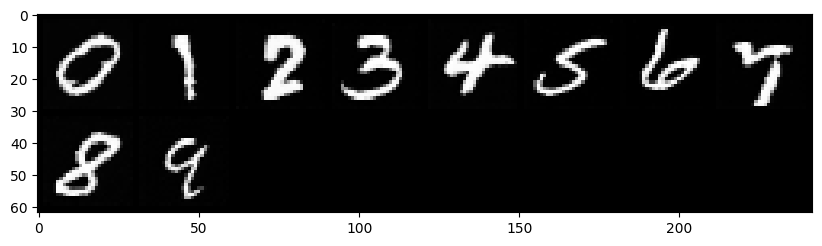

Finished epoch 7. Average of the last 100 loss values: 0.028125


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

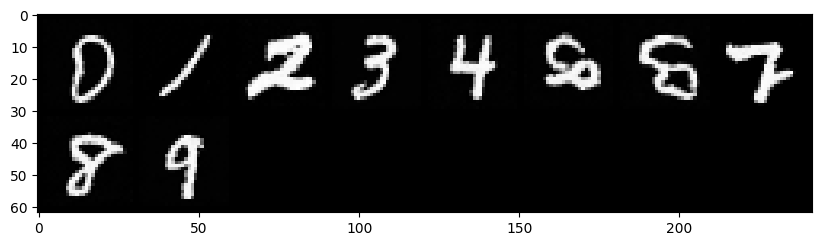

Finished epoch 8. Average of the last 100 loss values: 0.027344


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

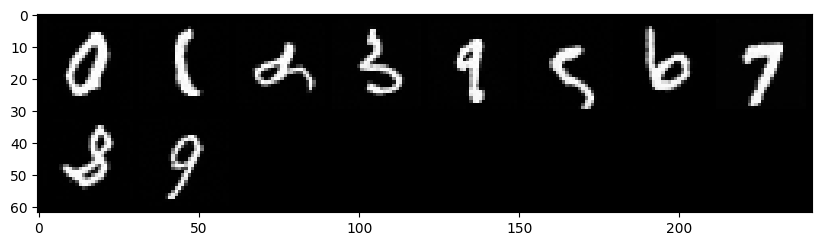

Finished epoch 9. Average of the last 100 loss values: 0.027281


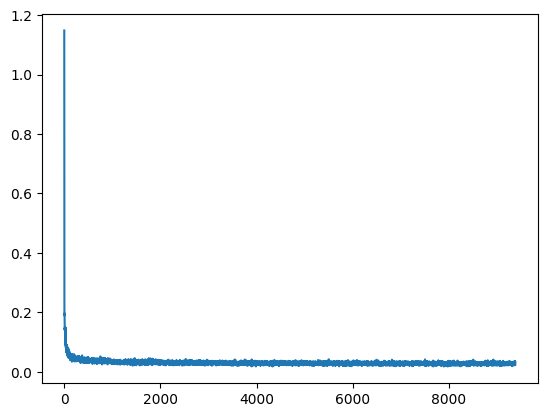

In [42]:

# How many runs through the data should we do?
n_epochs = 10

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader,total=len(train_dataloader),leave=False):
        
        # Get some data and prepare the corrupted version
        x = x.to(device) 
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = unet(noisy_x, timesteps, y).sample # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        
    generate_image()

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
        

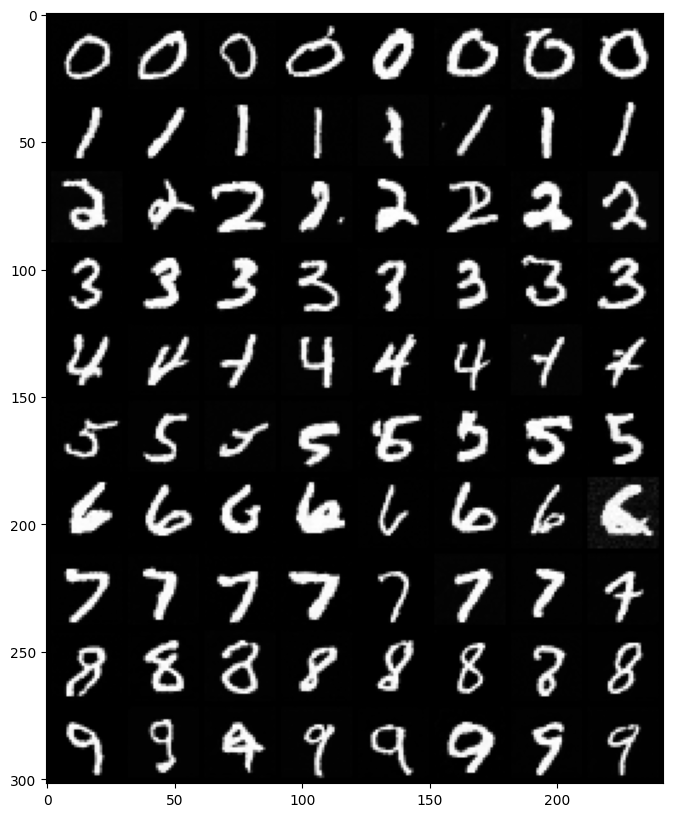

In [ ]:
xt = torch.randn(80,1,28,28).to(device)
y =  torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

unet.eval()

for t in tqdm(scheduler.timesteps,total=scheduler.num_train_timesteps,leave=False):
    with torch.no_grad():
        noise_pred = unet(xt,t,y).sample
        
    
    xt = scheduler.step(noise_pred, t, xt).prev_sample
    
plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1,2,0).cpu().numpy())
plt.show()